In [1]:
import time 
start_time = time.time()

import evaluate # self-written
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from sklearn import tree, metrics, ensemble, model_selection
from xgboost import plot_importance
from xgboost.sklearn import XGBClassifier
from tensorflow import keras

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set_theme(style="darkgrid")
df = pd.read_csv('data/data_after_preprocessing.csv')

### Data Preprocessing

#### Text Processing

In [2]:
# Lemmatization
import nltk
nltk.download('wordnet')

from nltk.stem.wordnet import WordNetLemmatizer
df['tweet'] = df['tweet'].apply(lambda x:' '.join(WordNetLemmatizer().lemmatize(i) for i in x.split(' ')))

# Remove punctuation
df['tweet'] = df['tweet'].str.replace('[^\w\s]','')

[nltk_data] Downloading package wordnet to /Users/yanjin/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
# Run tf vectorizer

from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV

# Adding a list of stop words to the wordlist
my_stop_words = text.ENGLISH_STOP_WORDS.union(['suicidal'])

count_vectorizer = CountVectorizer(min_df=0.01, stop_words=my_stop_words)

# Use vectors for LDA

x = count_vectorizer.fit_transform(df['tweet'])
lda_model = LatentDirichletAllocation(n_components=5, learning_decay=0.7, random_state=2021)
xtr = lda_model.fit_transform(x)

# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda_model.score(x))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda_model.perplexity(x))

data_x = pd.DataFrame(xtr).add_prefix('topic_')

Log Likelihood:  -234533.78816095446
Perplexity:  146.79236506626245


In [4]:
from sklearn import preprocessing ,model_selection

# Take log for some features and generate data_x
features_to_log = ['nlikes', 'nreplies', 'nretweets', 'tweets', 'following', 'followers', 'likes', 'media']
for feature in features_to_log:
    data_x[feature] = np.log1p(df[feature])
    
# 'day' take absolute values.
df['day'] = (df['day'] - 4).abs()

# Adding features
features_to_add = ['day','reply_to', 'url','join_time', 'day_after','tweet_length', 'tweet_sentiment', 'bio_sentiment', 'first_person', 'second_person', 'third_person']
for feature in features_to_add:
    data_x[feature] = df[feature]
    
scaler = preprocessing.MinMaxScaler()
data_x.iloc[:, 5:] = scaler.fit_transform(data_x.iloc[:, 5:])
data_y = df['label']

In [5]:
num_features = data_x.shape
num_classes = 2

In [6]:
data_x.dtypes

topic_0            float64
topic_1            float64
topic_2            float64
topic_3            float64
topic_4            float64
nlikes             float64
nreplies           float64
nretweets          float64
tweets             float64
following          float64
followers          float64
likes              float64
media              float64
day                float64
reply_to           float64
url                float64
join_time          float64
day_after          float64
tweet_length       float64
tweet_sentiment    float64
bio_sentiment      float64
first_person       float64
second_person      float64
third_person       float64
dtype: object

In [7]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(data_x, data_y, test_size = 0.2, random_state = 1016)

## Logistics Regression

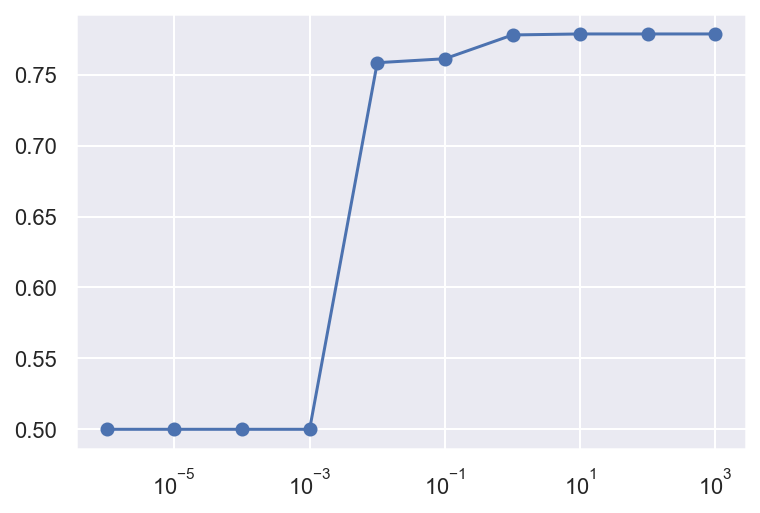

In [8]:
import matplotlib.pyplot as plt
from sklearn import linear_model, metrics
num_C = 10
C = [1.0] * num_C
for i in range(num_C):
    C[i] = pow(10, i - 6)
logit_multi = [0] * num_C
precision = [0] * num_C
recall = [0] * num_C
auc = [0] * num_C

for i in range(num_C):
    logit_multi[i] = linear_model.LogisticRegression(
        class_weight='balanced',
        penalty='l1', 
        solver='liblinear',
        C=C[i],
        max_iter=1000)
    logit_multi[i].fit(x_train, y_train)
    auc[i] = metrics.roc_auc_score(y_test, logit_multi[i].predict(x_test))

plt.xscale('log')
plt.plot(C, auc, 'bo-')
plt.show()

In [9]:
# Select C = 0.01
estimator = linear_model.LogisticRegression(penalty='l1', solver='liblinear',class_weight='balanced', C=0.1, max_iter=1000)

estimator.fit(x_train, y_train)
y_pred_proba = estimator.predict_proba(x_test)
dic = evaluate.threshold(y_pred_proba,y_test)
print('Selected threshold: ', dic['threshold'])
print(evaluate.performance(y_test, dic['y_pred'],y_pred_proba)['report'])

Selected threshold:  0.34

The evaluation report of classification is:
Confusion Matrix:
[[846 576]
 [ 39 387]]
Accuracy: 0.6672077922077922
Precision: 0.40186915887850466
Recall: 0.9084507042253521
F2 Score: 0.7255343082114736
AUC Score: 0.8471240004490139



In [10]:
# If we interpret the importance of features by the absolute value of coefficients, we can get the 5 most important features
np.take(x_train.columns,np.argsort(np.abs(estimator.coef_[0]))[::-1])[:5]

Index(['topic_4', 'first_person', 'day', 'join_time', 'tweet_length'], dtype='object')

## Single Decision Tree

Optimal max_tree_depth and it's mean cross validation score(AUC):  5 0.813849432759913


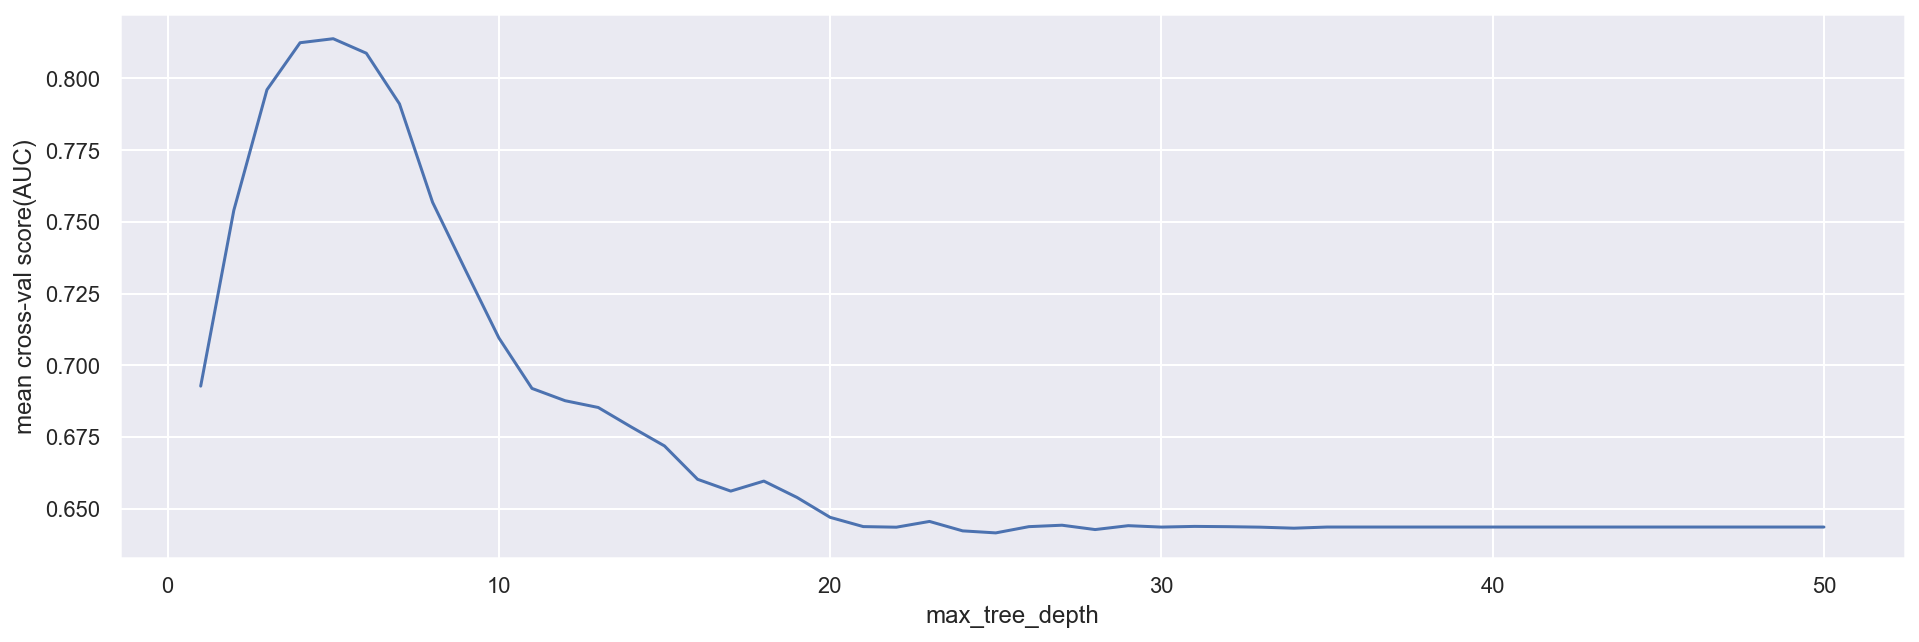

In [11]:
cv_score = []
num_CV = 50

for i in range(num_CV):
    dt_clf = tree.DecisionTreeClassifier(max_depth = i + 1, random_state = 1016, class_weight = 'balanced')
    score = model_selection.cross_val_score(dt_clf, x_train, y_train, scoring = "roc_auc", cv = 10).mean()
    cv_score.append(score)
cv_score = np.array(cv_score)

optimal_depth = (np.argmax(cv_score) + 1)
print("Optimal max_tree_depth and it's mean cross validation score(AUC): ", optimal_depth, cv_score[np.argmax(cv_score)])

plt.figure(figsize=(16,5))
sns.lineplot(data = pd.DataFrame({
    'max_tree_depth': range(1, num_CV + 1),
    'mean cross-val score(AUC)': cv_score
    }), x = "max_tree_depth", y = 'mean cross-val score(AUC)',
)
plt.show()

Optimal min_samples_split and it's mean cross validation score(AUC):  2 0.813849432759913
Optimal min_samples_leaf and it's mean cross validation score(AUC):  10 0.8160021737835745


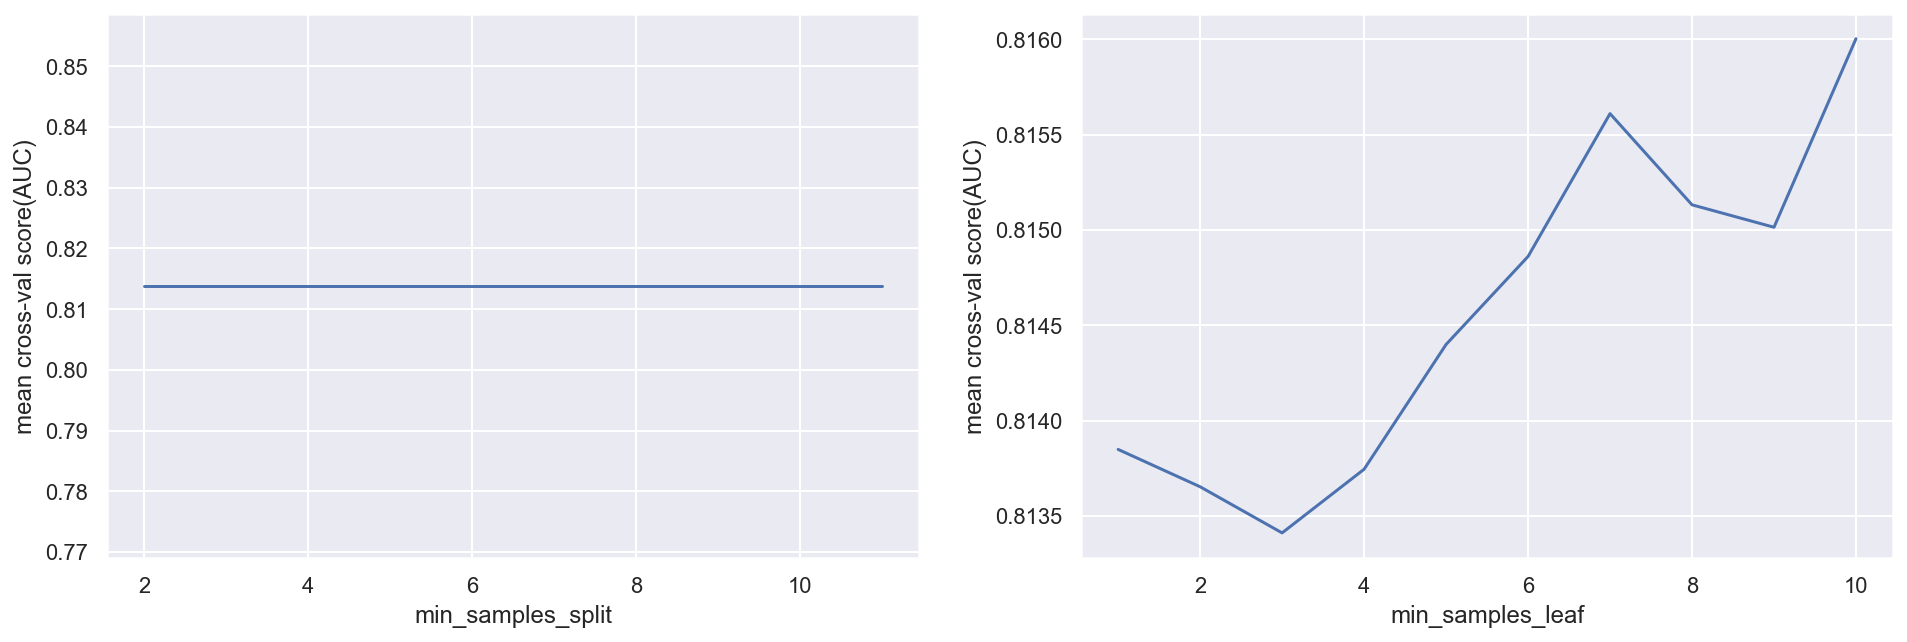

In [12]:
plt.figure(figsize = [16,5])
cv_score = []
num_CV = 10

# Tuning min_samples_split
for i in range(num_CV):
    dt_clf = tree.DecisionTreeClassifier(
        max_depth = optimal_depth, 
        min_samples_split = i + 2, 
        random_state = 1016, 
        class_weight = 'balanced'
    )
    score = model_selection.cross_val_score(dt_clf, x_train, y_train, scoring = "roc_auc", cv = 10).mean()
    cv_score.append(score)
cv_score = np.array(cv_score)

optimal_split = np.argmax(cv_score) + 2
print("Optimal min_samples_split and it's mean cross validation score(AUC): ", optimal_split, cv_score[np.argmax(cv_score)])  

plt.subplot(1, 2, 1)
sns.lineplot(data = pd.DataFrame({
    'min_samples_split': range(2, num_CV + 2),
    'mean cross-val score(AUC)': cv_score
    }), x = "min_samples_split", y = 'mean cross-val score(AUC)',
)

cv_score = []
# Tuning min_samples_leaf
for i in range(num_CV):
    dt_clf = tree.DecisionTreeClassifier(
        max_depth = optimal_depth, 
        min_samples_split = optimal_split, 
        min_samples_leaf = i + 1,
        random_state = 1016, 
        class_weight = 'balanced'
    )
    score = model_selection.cross_val_score(dt_clf, x_train, y_train, scoring = "roc_auc", cv = 10).mean()
    cv_score.append(score)
cv_score = np.array(cv_score)

optimal_leaf = np.argmax(cv_score) + 1
print("Optimal min_samples_leaf and it's mean cross validation score(AUC): ", optimal_leaf, cv_score[np.argmax(cv_score)])  
plt.subplot(1, 2, 2)
sns.lineplot(data = pd.DataFrame({
    'min_samples_leaf': range(1, num_CV + 1),
    'mean cross-val score(AUC)': cv_score
    }), x = "min_samples_leaf", y = 'mean cross-val score(AUC)',
)

plt.show()

In [13]:
param_grid = {
    'max_depth': np.arange(1, 10),
    'min_samples_leaf': np.arange(1, 10),
}

dt_clf = tree.DecisionTreeClassifier(random_state = 1016, class_weight = 'balanced')
GS = model_selection.GridSearchCV(dt_clf, param_grid, scoring = 'roc_auc', n_jobs = -1, cv = 10)
GS.fit(x_train, y_train) 

for k, v in GS.best_params_.items():
    print("Optimal {} = {}".format(k, v))

print("Best model's AUC score: {}".format(GS.best_score_))

Optimal max_depth = 6
Optimal min_samples_leaf = 9
Best model's AUC score: 0.8159113632583942


In [14]:
dt_clf = GS.best_estimator_
y_pred_proba = dt_clf.predict_proba(x_test)

y_pred = evaluate.threshold(y_pred_proba, y_test)['y_pred']
print(evaluate.performance(y_test, y_pred, y_pred_proba)['report'])


The evaluation report of classification is:
Confusion Matrix:
[[800 622]
 [ 43 383]]
Accuracy: 0.6401515151515151
Precision: 0.38109452736318405
Recall: 0.8990610328638498
F2 Score: 0.7069029162052417
AUC Score: 0.8156418586530906



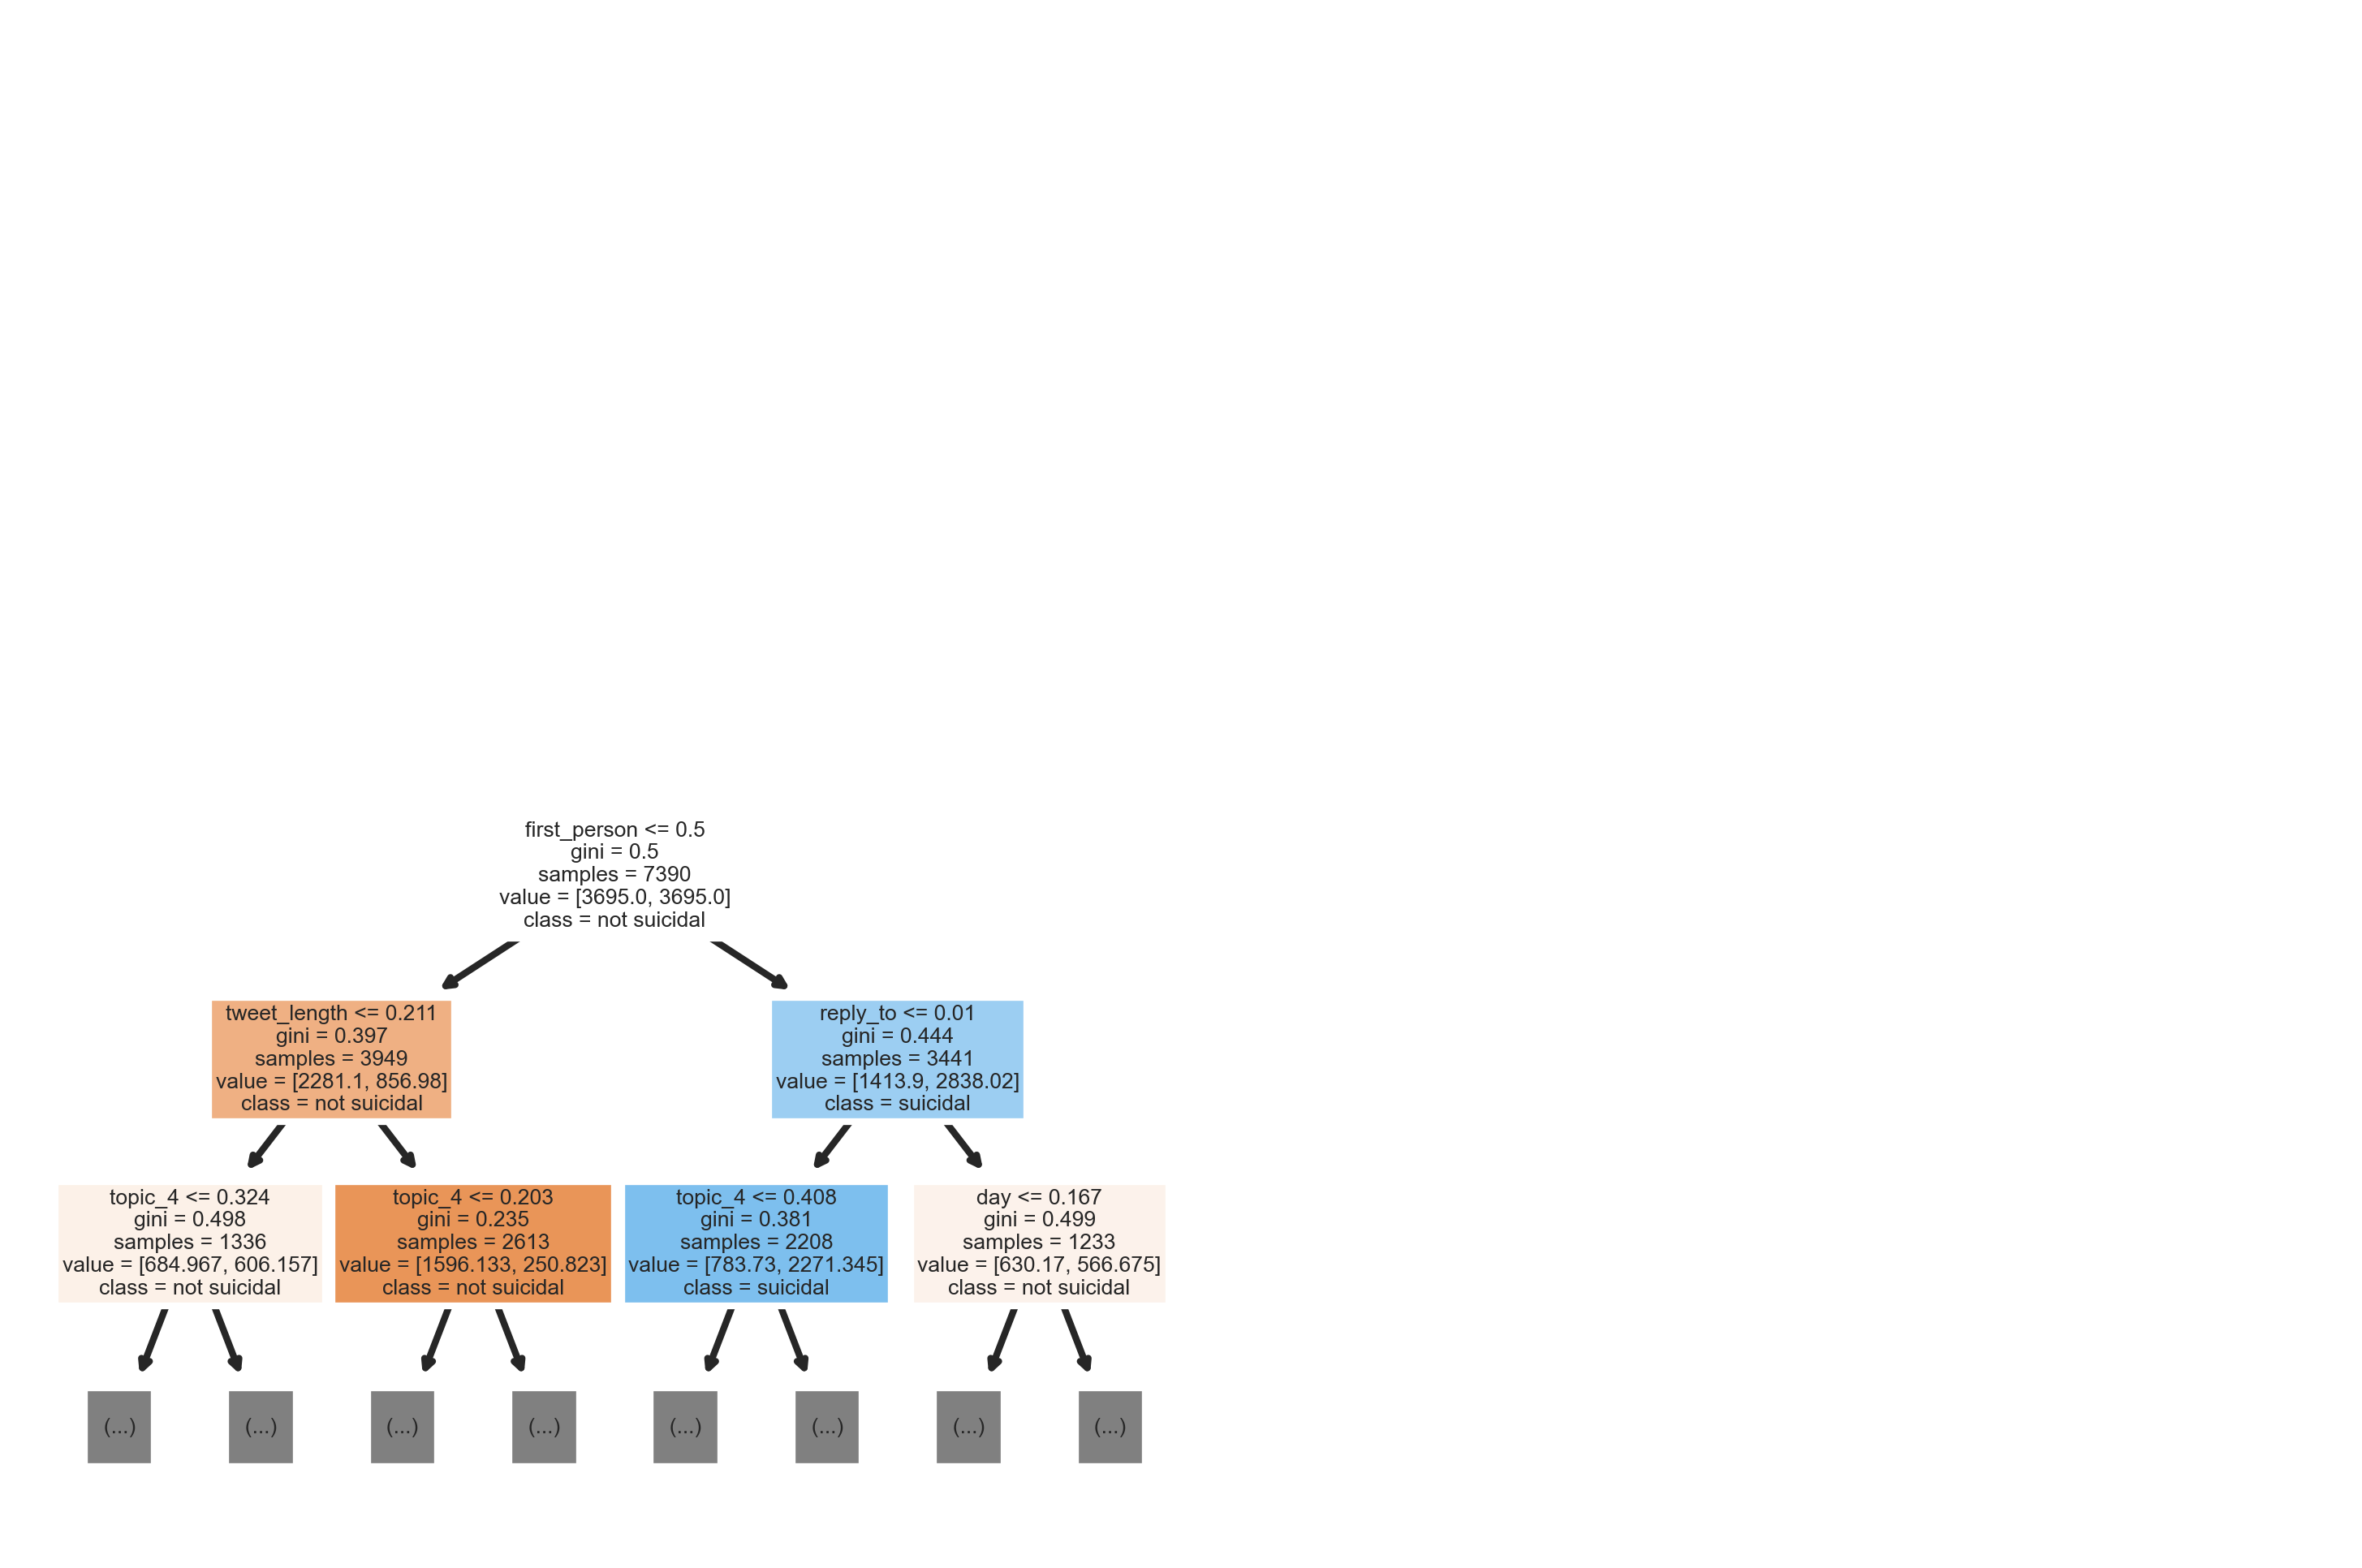

In [15]:
fig = plt.figure(dpi = 300)
tree.plot_tree(
    dt_clf, 
    max_depth = 2,
    feature_names = data_x.columns,  
    class_names = ['not suicidal', 'suicidal'],
    filled = True
)
fig.savefig("decistion_tree.png")

## XGBoost

In [16]:
param_grid = {
    'max_depth':[3, 5, 7, 9],
    'min_child_weight':[1, 3, 5],
}

GS = model_selection.GridSearchCV(
    estimator = XGBClassifier(use_label_encoder = False),
    param_grid = param_grid,
    n_jobs = -1,
    cv = 5,
    scoring = 'roc_auc',
    verbose = 4
)

GS.fit(x_train, y_train)
for k, v in GS.best_params_.items():
    print("Optimal {} = {}".format(k, v))

print("Best model's AUC score: {}".format(GS.best_score_))

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[23:49:05] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Optimal max_depth = 3
Optimal min_child_weight = 5
Best model's AUC score: 0.8620418073961907


In [17]:
param_grid = {
    'learning_rate': [0.001, 0.01, 0.05, 0.1, 0.2],
    'n_estimators': range(100, 1001, 100),
}
GS = model_selection.GridSearchCV(
    estimator = XGBClassifier(max_depth = 3, min_child_weight = 5, use_label_encoder = False),
    param_grid = param_grid,
    n_jobs = -1,
    cv = 5,
    scoring = 'roc_auc',
    verbose = 4
)

GS.fit(x_train, y_train)
for k, v in GS.best_params_.items():
    print("Optimal {} = {}".format(k, v))

print("Best model's AUC score: {}".format(GS.best_score_))

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[23:54:22] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Optimal learning_rate = 0.05
Optimal n_estimators = 300
Best model's AUC score: 0.8665038460753995


In [18]:
xgb_clf = XGBClassifier(n_estimators = 300, max_depth = 3, min_child_weight = 5, learning_rate = 0.05, use_label_encoder = False)
xgb_clf.fit(x_train, y_train)
y_pred_proba = xgb_clf.predict_proba(x_test)
y_pred = evaluate.threshold(y_pred_proba, y_test)['y_pred']
print(evaluate.performance(y_test, y_pred, y_pred_proba)['report'])

[23:54:23] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

The evaluation report of classification is:
Confusion Matrix:
[[1092  330]
 [  55  371]]
Accuracy: 0.7916666666666666
Precision: 0.5292439372325249
Recall: 0.8708920187793427
F2 Score: 0.7713097713097713
AUC Score: 0.8805672761368963



<Figure size 1800x1200 with 0 Axes>

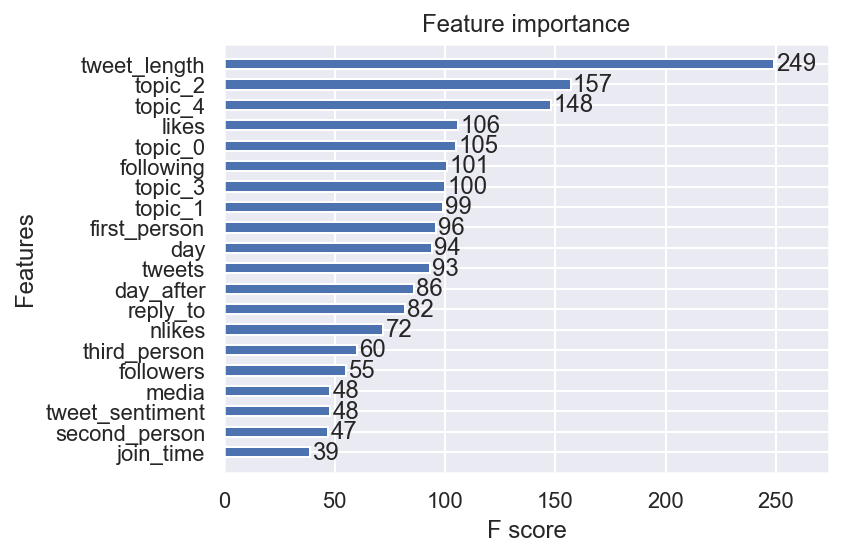

In [19]:
fig = plt.figure(dpi = 300)
ax = plot_importance(xgb_clf, max_num_features=20, height=0.5)
ax.figure.tight_layout()
ax.figure.savefig("xgboost_feature.png")

## Neural Network (Fully Connected)

In [20]:
METRICS = [
    keras.metrics.TruePositives(name='tp'),
    keras.metrics.FalsePositives(name='fp'),
    keras.metrics.TrueNegatives(name='tn'),
    keras.metrics.FalseNegatives(name='fn'), 
    keras.metrics.BinaryAccuracy(name='accuracy'),
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall'),
    keras.metrics.AUC(name='auc'),
]
    
model = keras.Sequential([
    keras.layers.Input(shape = (24, )),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(1, activation='sigmoid')
])

model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.BinaryCrossentropy(from_logits = True),
    metrics = METRICS
)

In [21]:
total = len(data_x)
pos = np.count_nonzero(data_x.iloc[:,-1])
neg = total - pos

weight_for_0 = (1 / neg) * (total) / 2.0 
weight_for_1 = (1 / pos) * (total) / 2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.70
Weight for class 1: 1.73


In [22]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_auc', 
    verbose = 1,
    patience = 10,
    mode = 'max',
    restore_best_weights = True
)

history = model.fit(
    x = x_train, y = y_train,
    batch_size = 256,
    validation_split = 0.2,
    epochs = 100,
    callbacks = [early_stopping],
    class_weight = class_weight,
    verbose = 0
)

Restoring model weights from the end of the best epoch.
Epoch 00070: early stopping


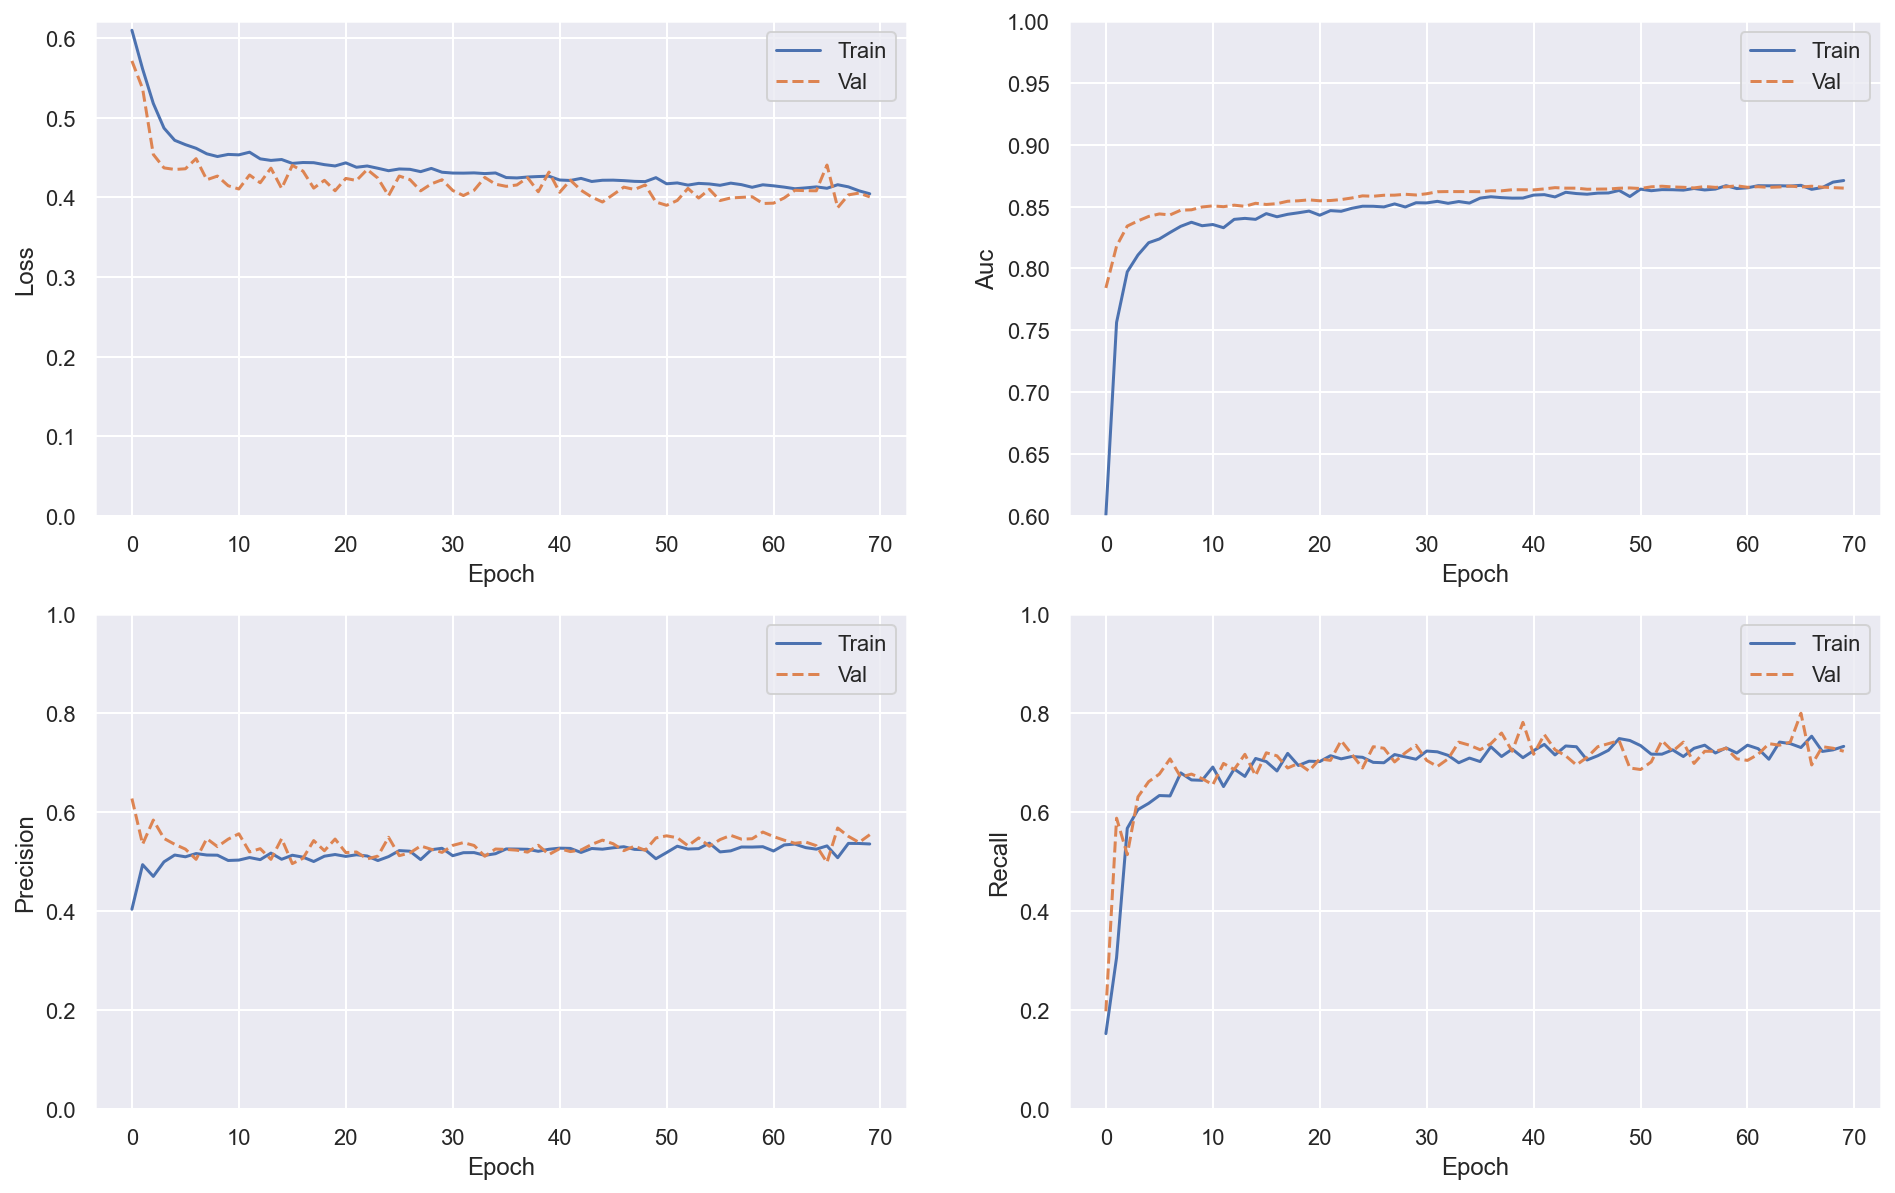

In [23]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
metrics = ['loss', 'auc', 'precision', 'recall']

plt.figure(figsize=(16, 10))
for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2, 2, n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric], color=colors[1], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
        plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
        plt.ylim([0.6,1])
    else:
        plt.ylim([0,1])
    plt.legend()

In [24]:
y_pred_proba = model.predict(x_test)
y_pred_proba = np.hstack((y_pred_proba, y_pred_proba))

y_pred = evaluate.threshold(y_pred_proba, y_test)['y_pred']
print(evaluate.performance(y_test, y_pred, y_pred_proba)['report'])


The evaluation report of classification is:
Confusion Matrix:
[[909 513]
 [ 33 393]]
Accuracy: 0.7045454545454546
Precision: 0.4337748344370861
Recall: 0.9225352112676056
F2 Score: 0.7528735632183909
AUC Score: 0.8678446676307258



In [25]:
end_time = time.time()

print("Time: {0:.2f}s".format(end_time - start_time))

Time: 434.28s
